In [20]:
import os
import time
import glob

import pandas as pd
import polars as pl
import numpy as np
import xgboost as xgb
import cudf
from sklearn.model_selection import GroupKFold
import joblib
from matplotlib import pyplot as plt
import dask.dataframe as ddf

In [21]:
DATASET_PATH = "/home/search2/lichunyu/otto-recommender-system/data/input"
# TRAIN_SESSION_SAMPLE_SIZE = 5e6
TRAIN_SESSION_SAMPLE_SIZE = 5e3
DOWNSAMPLE_RATE = 20
TYPE_MAP = {'clicks':0, 'carts':1, 'orders':2}

def read_parquet(f):
    df = pd.read_parquet(f)
    df.ts = (df.ts/1000).astype('int32')
    df['type'] = df['type'].map(TYPE_MAP).astype('int8')
    return df

In [6]:
train_files: list = sorted(glob.glob(os.path.join(DATASET_PATH, "otto-validation/train_parquet/*.parquet")))
# train_files

In [4]:
test_files: list = sorted(glob.glob(os.path.join(DATASET_PATH, "otto-validation/test_parquet/*.parquet")))
# test_files

In [102]:
%%time
df_train = pd.concat([read_parquet(t) for t in train_files[0:4]])
df_train = pd.concat([read_parquet(t) for t in train_files[0:4]])
df_train = df_train[df_train["session"].isin(pd.DataFrame(np.random.choice(df_train.session.unique(), int(TRAIN_SESSION_SAMPLE_SIZE))).rename({0: "session"}, axis=1)["session"])]
train_ts_maximal = df_train["ts"].max()
train_ts_minimal = df_train["ts"].min()
df_train_label = df_train[(train_ts_maximal-df_train["ts"]) < 24*60*60].reset_index(drop=True)
df_train = df_train[(train_ts_maximal-df_train["ts"]) >= 24*60*60].reset_index(drop=True)
df_train_label["label"] = 1
df_train_label = df_train_label[["session", "aid", "label"]].drop_duplicates(subset=["session", "aid"])
df_train = df_train.merge(df_train_label[["session", "aid", "label"]], on=["session", "aid"], how="outer").fillna({"label": 0, "type": 3, "ts": train_ts_minimal})
df_train["label"] = df_train["label"].astype("int8")
df_train["type"].value_counts()
df_train["ts"] = df_train["ts"].astype("int32")
df_train

CPU times: user 2.63 s, sys: 891 ms, total: 3.52 s
Wall time: 3.69 s


,session,aid,ts,type,label
0,51,1665465,1659304800,1.0,0
1,51,1665465,1659305128,2.0,0
2,51,1139104,1659304816,1.0,0
3,51,1139104,1659304887,0.0,0
4,51,1211207,1659379271,0.0,0
...,...,...,...,...,...
181232,439202,861446,1659304800,3.0,1
181233,439202,1572556,1659304800,3.0,1
181234,439202,1108759,1659304800,3.0,1
181235,439202,1030279,1659304800,3.0,1


In [29]:
%%time

OFFSET = 0

aid_candidates = df_train["aid"].unique()

df_train = pd.concat([read_parquet(t) for t in train_files[0:4]])

df_train = df_train[df_train["session"].isin(pd.DataFrame(np.random.choice(df_train.session.unique(), int(TRAIN_SESSION_SAMPLE_SIZE))).rename({0: "session"}, axis=1)["session"])]
train_ts_maximal = df_train["ts"].max()
df_train_label = df_train[((train_ts_maximal-df_train["ts"]) < (OFFSET+14)*24*60*60)&((train_ts_maximal-df_train["ts"]) >= (OFFSET)*24*60*60)].reset_index(drop=True)
df_train_label = df_train_label[(df_train_label["type"]==TYPE_MAP["carts"])|(df_train_label["type"]==TYPE_MAP["orders"])]
df_train_label = df_train_label.sort_values(['session','ts'],ascending=[True,True])
df_train_label['n'] = df_train_label.groupby('session').cumcount()
df_train_label = df_train_label.loc[df_train_label.n<20].drop('n',axis=1)
df_train_label

df_train = df_train[((train_ts_maximal-df_train["ts"]) >= (OFFSET+14)*24*60*60)&((train_ts_maximal-df_train["ts"]) < (OFFSET+21)*24*60*60)].reset_index(drop=True)
df_train_label["label"] = 1
df_train_label = df_train_label[["session", "aid", "label"]].drop_duplicates(subset=["session", "aid"])
train_ts_minimal = df_train["ts"].min()
df_train = df_train.merge(df_train_label[["session", "aid", "label"]], on=["session", "aid"], how="outer").fillna({"label": 0, "type": 3, "ts": train_ts_minimal})
# df_train = df_train.merge(df_train_label[["session", "aid", "label"]], on=["session", "aid"], how="left").fillna({"label": 0, "type": 3, "ts": train_ts_minimal})
df_train["label"] = df_train["label"].astype("int8")
df_train["type"] = df_train["type"].astype("int8")
df_train["ts"] = df_train["ts"].astype("int32")
df_train["label"].value_counts()
df_train_label

CPU times: user 1.46 s, sys: 306 ms, total: 1.77 s
Wall time: 1.32 s


,session,aid,label
22,273,1322740,1
23,273,416371,1
24,273,263752,1
25,273,1315485,1
26,273,1655440,1
...,...,...,...
98000,442621,570663,1
98002,442621,1027277,1
98022,442867,765745,1
98034,442970,1443006,1


In [28]:
df_train["label"].value_counts()

0    87620
1     7153
Name: label, dtype: int64

In [ ]:
def carts_count(df):
    df_tmp = df[df["type"]==""]

In [ ]:
def downsample(df, candidates=None, n=-1):
    ts_minimal = df["ts"].min()
    session_num = TRAIN_SESSION_SAMPLE_SIZE
    session_list = df["session"].unique()
    if n == -1:
        n = DOWNSAMPLE_RATE
    if candidates is None:
        candidates = []
    df_negative = df[df["label"]==0]
    df_postive = df[df["label"]==1]
    r = len(df_negative)/len(df_postive)
    print(f"current negative size: {len(df_negative)}, postive size: {len(df_postive)}, rate: {r}")
    if r > 20:
        gloden_negative_size = n * len(df_postive)
        df_negative = df_negative.sample(gloden_negative_size)
        df = pd.concat([df_postive, df_negative])
    elif r < 20:
        gloden_negative_size = n * len(df_postive)
        difference = gloden_negative_size - len(df_negative)
        session_difference = difference // session
        data4df = {"session": [], "aid": []}
        for i in session_list:
            data4df["aid"].append(np.random.choice(candidates, session_difference).tolist())
            data4df["session"].append(i)
        df_addition = pd.DataFrame(data4df)
        df_addition = df_addition.explode("aid")
        

        df_addition["label"] = 0
        df_addition["ts"] = ts_minimal
        df_addition["type"] = 3
        
        df = pd.concat([df_postive, df_negative, df_addition])
        df = df.drop_duplicates(subset=["session", "aid", "ts"])
    df["_noise"] = np.random.randn(len(df))
    df = df.sort_values(["session", "_noise"])
    df = df.drop("_noise", axis=1).reset_index(drop=True)
    return df

In [104]:
def rate_pd(df):
    def func(x):
        x_clicks = x[x["type"]==TYPE_MAP["clicks"]]
        x_carts = x[x["type"]==TYPE_MAP["carts"]]
        x_orders = x[x["type"]==TYPE_MAP["orders"]]
        
        hit_clicks_carts = x_carts.merge(x_clicks, on="aid", how="inner").drop_duplicates()
        hit_orders_carts = x_carts.merge(x_orders, on="aid", how="inner").drop_duplicates()
        hit_orders_clicks = x_clicks.merge(x_orders, on="aid", how="inner").drop_duplicates()

        rate_clicks_in_carts = (len(hit_clicks_carts)/len(x_carts)) if len(x_carts) != 0 else 0
        rate_clicks_in_orders = (len(hit_orders_clicks)/len(x_orders)) if len(x_orders) != 0 else 0
        rate_carts_in_clicks = (len(hit_clicks_carts)/len(x_clicks)) if len(x_clicks) != 0 else 0
        rate_carts_in_orders = (len(hit_orders_carts)/len(x_orders)) if len(x_orders) != 0 else 0
        rate_orders_in_clicks = (len(hit_orders_clicks)/len(x_clicks)) if len(x_clicks) != 0 else 0
        rate_orders_in_carts = (len(hit_orders_carts)/len(x_carts)) if len(x_carts) != 0 else 0

        r = pd.Series({
            "rate_clicks_in_carts": rate_clicks_in_carts,
            "rate_clicks_in_orders": rate_clicks_in_orders,
            "rate_carts_in_clicks": rate_carts_in_clicks,
            "rate_carts_in_orders": rate_carts_in_orders,
            "rate_orders_in_clicks": rate_orders_in_clicks,
            "rate_orders_in_carts": rate_orders_in_carts
        })
        return r
    df_tmp = df[["session", "aid", "ts", "type"]].groupby("session")[["aid", "type"]].apply(func)
    df = df.merge(df_tmp, on="session")
    return df




def clicks_rate_in_orders(df):
    def func(x):
        x_clicks = x[x["type"]==TYPE_MAP["clicks"]]
        x_orders = x[x["type"]==TYPE_MAP["orders"]]
        x_hit = x_orders.merge(x_clicks, on="aid", how="inner").drop_duplicates()
        rate = (len(x_hit) / len(x_orders)) if len(x_orders) != 0 else 0
        dual_rate = (len(x_orders) / len(x_hit)) if len(x_hit) != 0 else 0
#         r = pd.Series({"clicks_rate_in_orders": rate})
        r = pd.Series({"clicks_rate_in_orders": rate, "orders_rate_in_clicks": dual_rate})
        return r
    df_tmp = df[["session", "aid", "ts", "type"]].groupby("session")[["aid", "type"]].apply(func)
    df = df.merge(df_tmp, on="session")
    return df

def carts_rate_in_orders(df):
    def func(x):
        x_carts = x[x["type"]==TYPE_MAP["carts"]]
        x_orders = x[x["type"]==TYPE_MAP["orders"]]
        x_hit = x_orders.merge(x_carts, on="aid", how="inner").drop_duplicates()
        rate = (len(x_hit) / len(x_orders)) if len(x_orders) != 0 else 0
        dual_rate = (len(x_orders) / len(x_hit)) if len(x_hit) != 0 else 0
        r = pd.Series({"carts_rate_in_orders": rate, "orders_rate_in_carts": dual_rate})
        return r
    df_tmp = df[["session", "aid", "ts", "type"]].groupby("session")[["aid", "type"]].apply(func)
    df = df.merge(df_tmp, on="session")
    return df


In [ ]:
bt = time.time()
df_train = rate_pd(df_train)
print(f"cost time: {time.time()-bt}s")

In [36]:
df_train = pl.DataFrame(df_train)
df_train

session,aid,ts,type,label
i32,i32,i32,f64,i8
329,1617833,1659304805,0.0,0
329,686194,1659304861,0.0,0
329,866511,1659371891,0.0,0
329,866511,1659371971,0.0,0
329,866511,1659372303,0.0,0
329,866511,1659372653,0.0,0
329,665959,1659371988,0.0,0
329,665959,1659372271,0.0,0
329,1085758,1659372077,0.0,0


In [94]:
def rate(df):
    df = df.join(df[["session", "aid", "ts", "type"]].groupby("session").agg([
        (((pl.col("type")==TYPE_MAP["carts"])&(pl.col("type")==TYPE_MAP["orders"])).sum()/(pl.col("type")==TYPE_MAP["orders"]).sum()).alias("carts_rate_in_orders"),
        (((pl.col("type")==TYPE_MAP["carts"])&(pl.col("type")==TYPE_MAP["orders"])).sum()/(pl.col("type")==TYPE_MAP["carts"]).sum()).alias("orders_rate_in_carts"),
        (((pl.col("type")==TYPE_MAP["clicks"])&(pl.col("type")==TYPE_MAP["orders"])).sum()/(pl.col("type")==TYPE_MAP["orders"]).sum()).alias("clicks_rate_in_orders"),
        (((pl.col("type")==TYPE_MAP["clicks"])&(pl.col("type")==TYPE_MAP["orders"])).sum()/(pl.col("type")==TYPE_MAP["clicks"]).sum()).alias("orders_rate_in_clicks"),
        (((pl.col("type")==TYPE_MAP["carts"])&(pl.col("type")==TYPE_MAP["clicks"])).sum()/(pl.col("type")==TYPE_MAP["clicks"]).sum()).alias("carts_rate_in_clicks"),
        (((pl.col("type")==TYPE_MAP["carts"])&(pl.col("type")==TYPE_MAP["clicks"])).sum()/(pl.col("type")==TYPE_MAP["carts"]).sum()).alias("clicks_rate_in_carts"),
    ]), on=["session"])
#     df = df.with_column(
#         pl.col([
#             "carts_rate_in_orders",
#             "orders_rate_in_carts",
#             "clicks_rate_in_orders",
#             "orders_rate_in_clicks",
#             "carts_rate_in_clicks",
#             "clicks_rate_in_carts"
#         ]).fill_nan(pl.lit(0)),
#     )
    return df.to_pandas()


df_tmp = rate(df_train)
df_tmp
# print(f"cost time: {time.time()-bt}s")

,session,aid,ts,type,label,carts_rate_in_orders,orders_rate_in_carts,clicks_rate_in_orders,orders_rate_in_clicks,carts_rate_in_clicks,clicks_rate_in_carts
0,329,1617833,1659304805,0.0,0,NaN,NaN,NaN,0.0,0.0,NaN
1,329,686194,1659304861,0.0,0,NaN,NaN,NaN,0.0,0.0,NaN
2,329,866511,1659371891,0.0,0,NaN,NaN,NaN,0.0,0.0,NaN
3,329,866511,1659371971,0.0,0,NaN,NaN,NaN,0.0,0.0,NaN
4,329,866511,1659372303,0.0,0,NaN,NaN,NaN,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
181403,443039,1325727,1659304805,3.0,1,0.0,0.0,0.0,0.0,0.0,0.0
181404,443039,1482992,1659304805,3.0,1,0.0,0.0,0.0,0.0,0.0,0.0
181405,443039,503713,1659304805,3.0,1,0.0,0.0,0.0,0.0,0.0,0.0
181406,443039,155991,1659304805,3.0,1,0.0,0.0,0.0,0.0,0.0,0.0


In [95]:
df_tmp["carts_rate_in_orders"].value_counts()

0.0    92040
Name: carts_rate_in_orders, dtype: int64

In [85]:
df_train.join(df_train[["session", "aid", "ts", "type"]].groupby("session").agg([
    (((pl.col("type")==TYPE_MAP["carts"])&(pl.col("type")==TYPE_MAP["orders"])).sum()/(pl.col("type")==TYPE_MAP["orders"]).sum()).alias("carts_rate_in_orders"),
    (((pl.col("type")==TYPE_MAP["carts"])&(pl.col("type")==TYPE_MAP["orders"])).sum()/(pl.col("type")==TYPE_MAP["carts"]).sum()).alias("orders_rate_in_carts"),
    (((pl.col("type")==TYPE_MAP["clicks"])&(pl.col("type")==TYPE_MAP["orders"])).sum()/(pl.col("type")==TYPE_MAP["orders"]).sum()).alias("clicks_rate_in_orders"),
    (((pl.col("type")==TYPE_MAP["clicks"])&(pl.col("type")==TYPE_MAP["orders"])).sum()/(pl.col("type")==TYPE_MAP["clicks"]).sum()).alias("orders_rate_in_clicks"),
    (((pl.col("type")==TYPE_MAP["carts"])&(pl.col("type")==TYPE_MAP["clicks"])).sum()/(pl.col("type")==TYPE_MAP["clicks"]).sum()).alias("carts_rate_in_clicks"),
    (((pl.col("type")==TYPE_MAP["carts"])&(pl.col("type")==TYPE_MAP["clicks"])).sum()/(pl.col("type")==TYPE_MAP["carts"]).sum()).alias("clicks_rate_in_carts"),
]), on=["session"])

session,aid,ts,type,label,carts_rate_in_orders,orders_rate_in_carts,clicks_rate_in_orders,orders_rate_in_clicks,carts_rate_in_clicks,clicks_rate_in_carts
i32,i32,i32,f64,i8,f64,f64,f64,f64,f64,f64
329,1617833,1659304805,0.0,0,NaN,NaN,NaN,0.0,0.0,NaN
329,686194,1659304861,0.0,0,NaN,NaN,NaN,0.0,0.0,NaN
329,866511,1659371891,0.0,0,NaN,NaN,NaN,0.0,0.0,NaN
329,866511,1659371971,0.0,0,NaN,NaN,NaN,0.0,0.0,NaN
329,866511,1659372303,0.0,0,NaN,NaN,NaN,0.0,0.0,NaN
329,866511,1659372653,0.0,0,NaN,NaN,NaN,0.0,0.0,NaN
329,665959,1659371988,0.0,0,NaN,NaN,NaN,0.0,0.0,NaN
329,665959,1659372271,0.0,0,NaN,NaN,NaN,0.0,0.0,NaN
329,1085758,1659372077,0.0,0,NaN,NaN,NaN,0.0,0.0,NaN


In [97]:
df_train[["session", "aid", "ts", "type"]].groupby("session").agg([
    pl.col("type")
])

session,carts_rate_in_orders
i32,f64
408304,NaN
188736,NaN
356640,NaN
423680,0.0
266560,0.0
405344,NaN
203376,0.0
243824,NaN
196976,NaN


In [96]:
from multiprocessing import Pool

def parallel_run(func, df_list):
    cores_num = min([4])
    pool = Pool(cores_num)
    df = pool.map(func, df_list)
    pool.close()
    pool.join()
    return df

In [99]:
import time

def func(x):
    time.sleep(2)
    return x+1

x_list = [1,2,3,4,5,6,7,8]

bt = time.time()
y = parallel_run(func, x_list)
print(f"cost time: {time.time()-bt}s.")
y

cost time: 4.0544281005859375s.


[2, 3, 4, 5, 6, 7, 8, 9]

# EDA
user count: 11096179  
clicks item count: 1824585

# item feature
* 购买次数
* 点击次数
* carts次数
* 被多少用户购买过
* 被多少用户点击过
* 被多少用户carts过

# user feature
* 点击次数
* 购买次数
* carts次数
* 最近n天是否有行为记录
* 行为记录属于频繁还是

# interaction feature
* 用户内点击次数
* 用户内购买次数
* 用户内carts次数

# Item Feature

In [31]:
%%time
df_clicks_count = None
for f in train_files:
    df_tmp = read_parquet(f)
    df_tmp = df_tmp[df_tmp["type"]==0].groupby("aid").agg("count").reset_index()
    df_tmp = df_tmp[["aid", "session"]].rename({"session": "count"}, axis=1)
    if df_clicks_count is None:
        df_clicks_count = df_tmp
    else:
        df_clicks_count = pd.concat([df_clicks_count, df_tmp])
        df_clicks_count = df_clicks_count.groupby("aid").agg("sum").reset_index()
#     break
df_clicks_count = df_clicks_count.reset_index(drop=True)

CPU times: user 34.2 s, sys: 3.63 s, total: 37.8 s
Wall time: 33.1 s


In [65]:
# df_clicks_count["count"] = df_clicks_count["count"]//100
df_clicks_count.to_pickle(os.path.join(DATASET_PATH, "feature/clicks_count.pkl"))

<AxesSubplot: >

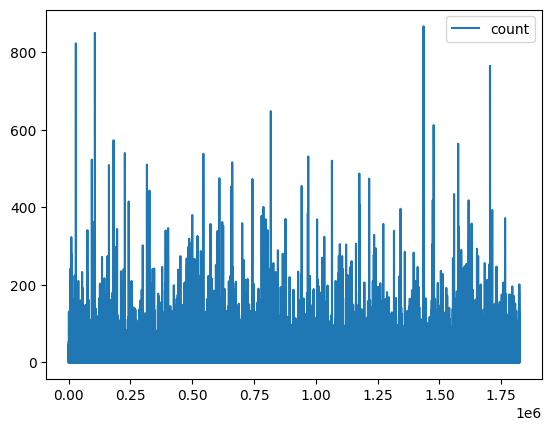

In [56]:
df_clicks_count[["count"]].plot()

In [57]:
%%time
df_carts_count = None
for f in train_files:
    df_tmp = read_parquet(f)
    df_tmp = df_tmp[df_tmp["type"]==TYPE_MAP["carts"]].groupby("aid").agg("count").reset_index()
    df_tmp = df_tmp[["aid", "session"]].rename({"session": "count"}, axis=1)
    if df_carts_count is None:
        df_carts_count = df_tmp
    else:
        df_carts_count = pd.concat([df_carts_count, df_tmp])
        df_carts_count = df_carts_count.groupby("aid").agg("sum").reset_index()
#     break
df_carts_count = df_carts_count.reset_index(drop=True)

CPU times: user 20.2 s, sys: 3.03 s, total: 23.3 s
Wall time: 18.7 s


In [63]:
df_carts_count["count"].unique().shape

(61,)

In [66]:
# df_carts_count["count"] = df_carts_count["count"]//100
df_carts_count.to_pickle(os.path.join(DATASET_PATH, "feature/carts_count.pkl"))

In [67]:
%%time
df_orders_count = None
for f in train_files:
    df_tmp = read_parquet(f)
    df_tmp = df_tmp[df_tmp["type"]==TYPE_MAP["orders"]].groupby("aid").agg("count").reset_index()
    df_tmp = df_tmp[["aid", "session"]].rename({"session": "count"}, axis=1)
    if df_orders_count is None:
        df_orders_count = df_tmp
    else:
        df_orders_count = pd.concat([df_orders_count, df_tmp])
        df_orders_count = df_orders_count.groupby("aid").agg("sum").reset_index()
#     break
df_orders_count = df_orders_count.reset_index(drop=True)

CPU times: user 16.2 s, sys: 2.03 s, total: 18.3 s
Wall time: 13.8 s


In [72]:
df_orders_count["count"] = df_orders_count["count"]//10

In [74]:
df_orders_count.to_pickle(os.path.join(DATASET_PATH, "feature/orders_count.pkl"))

# User Feature

## carts次数

In [13]:
df_carts_count = None
for f in train_files:
    df_tmp = read_parquet(f)
    df_tmp = df_tmp[df_tmp["type"]==TYPE_MAP["carts"]].groupby("session").agg("count").reset_index()
    df_tmp = df_tmp[["session", "aid"]].rename({"aid": "count"}, axis=1)
    if df_carts_count is None:
        df_carts_count = df_tmp
    else:
        df_carts_count = pd.concat([df_carts_count, df_tmp])
#     break
df_carts_count = df_carts_count.reset_index(drop=True)
df_carts_count

,session,count
0,0,3
1,1,8
2,3,21
3,5,1
4,9,1
...,...,...
3089890,11098382,1
3089891,11098409,1
3089892,11098423,2
3089893,11098444,2


In [17]:
df_carts_count.to_pickle(os.path.join(DATASET_PATH, "feature/session_carts_count.pkl"))

## clicks 次数

In [18]:
df_carts_count = None
for f in train_files:
    df_tmp = read_parquet(f)
    df_tmp = df_tmp[df_tmp["type"]==TYPE_MAP["clicks"]].groupby("session").agg("count").reset_index()
    df_tmp = df_tmp[["session", "aid"]].rename({"aid": "count"}, axis=1)
    if df_carts_count is None:
        df_carts_count = df_tmp
    else:
        df_carts_count = pd.concat([df_carts_count, df_tmp])
#     break
df_carts_count = df_carts_count.reset_index(drop=True)
df_carts_count

,session,count
0,0,142
1,1,19
2,2,13
3,3,200
4,4,2
...,...,...
11096174,11098523,1
11096175,11098524,1
11096176,11098525,1
11096177,11098526,1


In [19]:
df_carts_count.to_pickle(os.path.join(DATASET_PATH, "feature/session_clicks_count.pkl"))

## orders 次数

In [20]:
df_carts_count = None
for f in train_files:
    df_tmp = read_parquet(f)
    df_tmp = df_tmp[df_tmp["type"]==TYPE_MAP["orders"]].groupby("session").agg("count").reset_index()
    df_tmp = df_tmp[["session", "aid"]].rename({"aid": "count"}, axis=1)
    if df_carts_count is None:
        df_carts_count = df_tmp
    else:
        df_carts_count = pd.concat([df_carts_count, df_tmp])
#     break
df_carts_count = df_carts_count.reset_index(drop=True)
df_carts_count

,session,count
0,0,2
1,3,5
2,4,1
3,11,2
4,12,1
...,...,...
1314402,11098168,1
1314403,11098185,3
1314404,11098290,2
1314405,11098316,1


In [21]:
df_carts_count.to_pickle(os.path.join(DATASET_PATH, "feature/session_orders_count.pkl"))

In [11]:
read_parquet(test_files[-1])

,session,aid,ts,type
0,12809725,1080975,1661703782,0
1,12809726,46950,1661703782,0
2,12809727,1203591,1661703783,0
3,12809727,1203591,1661703793,1
4,12809728,543478,1661703783,0
...,...,...,...,...
316324,12899774,33035,1661723968,0
316325,12899775,1743151,1661723970,0
316326,12899776,548599,1661723972,0
316327,12899777,384045,1661723976,0


In [5]:
df = pd.read_pickle("/home/search2/lichunyu/otto-recommender-system/data/input/otto-validation/test_candidates/candidate_comatrix_exploded_details.pkl")
df

,session,aid,ts,type
0,11098528,11830,1661119200,0
1,11098528,1732105,1661119200,3
2,11098528,588923,1661119200,3
3,11098528,876129,1661119200,3
4,11098528,884502,1661119200,3
...,...,...,...,...
182272660,12899778,314422,1661119200,3
182272661,12899778,357194,1661119200,3
182272662,12899778,362673,1661119200,3
182272663,12899778,377330,1661119200,3


In [9]:
# bakcup

In [ ]:
%%time

# FEATURE_COL = [
#     "ts_day",
#     "carts_count",
#     "clicks_count",
#     "orders_count",
#     "session_clicks_count",
# ]

def ts_day(df):
    ts_minimal = df["ts"].min()
    df["ts_day"] = (df["ts"]-ts_minimal) // (24*60*60)
    return df

def carts_count(df):
    df_tmp = pd.read_pickle(os.path.join(DATASET_PATH, "feature/carts_count.pkl"))
    df = df.merge(df_tmp, on="aid", how="left").fillna({"count": 0}).rename({"count": "carts_count"}, axis=1)
    df["carts_count"] = df["carts_count"].astype("int32")
    return df

def clicks_count(df):
    df_tmp = pd.read_pickle(os.path.join(DATASET_PATH, "feature/clicks_count.pkl"))
    df = df.merge(df_tmp, on="aid", how="left").fillna({"count": 0}).rename({"count": "clicks_count"}, axis=1)
    df["clicks_count"] = df["clicks_count"].astype("int32")
    return df

def orders_count(df):
    df_tmp = pd.read_pickle(os.path.join(DATASET_PATH, "feature/orders_count.pkl"))
    df = df.merge(df_tmp, on="aid", how="left").fillna({"count": 0}).rename({"count": "orders_count"}, axis=1)
    df["orders_count"] = df["orders_count"].astype("int32")
    return df

def session_clicks_count(df):
    df_tmp = df[df["type"]==TYPE_MAP["clicks"]].groupby("session").agg({"aid": "count"}).reset_index().rename({"aid": "count"}, axis=1)
    df = df.merge(df_tmp, on="session", how="left").fillna({"count": 0}).rename({"count": "session_clicks_count"}, axis=1)
    df["session_clicks_count"] = df["session_clicks_count"].astype("int32")
    return df

def session_orders_count(df):
    df_tmp = df[df["type"]==TYPE_MAP["orders"]].groupby("session").agg({"aid": "count"}).reset_index().rename({"aid": "count"}, axis=1)
    df = df.merge(df_tmp, on="session", how="left").fillna({"count": 0}).rename({"count": "session_orders_count"}, axis=1)
    df["session_orders_count"] = df["session_orders_count"].astype("int32")
    return df

def session_carts_count(df):
    df_tmp = df[df["type"]==TYPE_MAP["carts"]].groupby("session").agg({"aid": "count"}).reset_index().rename({"aid": "count"}, axis=1)
    df = df.merge(df_tmp, on="session", how="left").fillna({"count": 0}).rename({"count": "session_carts_count"}, axis=1)
    df["session_carts_count"] = df["session_carts_count"].astype("int32")
    return df

def session_unknow_count(df):
    df_tmp = df[df["type"]==3].groupby("session").agg({"aid": "count"}).reset_index().rename({"aid": "count"}, axis=1)
    df = df.merge(df_tmp, on="session", how="left").fillna({"count": 0}).rename({"count": "session_unknow_count"}, axis=1)
    df["session_unknow_count"] = df["session_unknow_count"].astype("int32")
    return df

# ---- public -----
def add_session_length(df):
    # If not using cuDF, remove .to_pandas()
    df['session_length'] = df.groupby('session')['ts'].transform('count')
    return df

def add_action_num_reverse_chrono(df):
    df['action_num_reverse_chrono'] = df.session_length - df.groupby('session').cumcount() - 1
    return df

def add_log_recency_score(df):
    linear_interpolation = 0.1 + ((1-0.1) / (df['session_length']-1)) * (df['session_length']-df['action_num_reverse_chrono']-1)
    df['log_recency_score'] = (2 ** linear_interpolation - 1).fillna(1.0)
    return df

def add_type_weighted_log_recency_score(df):
    type_weights = {0:1, 1:6, 2:3}
    df['type_weighted_log_recency_score'] = df['log_recency_score'] / df['type'].map(type_weights)
    return df

# --- new ---

def carts_rate_in_clicks(df):
    def func(x):
        x_clicks = x[x["type"]==TYPE_MAP["clicks"]]
        x_carts = x[x["type"]==TYPE_MAP["carts"]]
        x_hit = x_clicks.merge(x_carts, on="aid", how="inner").drop_duplicates()
        rate = len(x_hit) / len(x_clicks) if len(x_clicks) != 0 else 0
        r = pd.Series({"carts_rate_in_clicks": rate})
        return r
    df_tmp = df[["session", "aid", "ts", "type"]].groupby("session")[["aid", "type"]].apply(func)
    df = df.merge(df_tmp, on="session")
    return df

def orders_rate_in_clicks(df):
    def func(x):
        x_clicks = x[x["type"]==TYPE_MAP["clicks"]]
        x_orders = x[x["type"]==TYPE_MAP["orders"]]
        x_hit = x_clicks.merge(x_orders, on="aid", how="inner").drop_duplicates()
        rate = len(x_hit) / len(x_clicks) if len(x_clicks) != 0 else 0
        r = pd.Series({"orders_rate_in_clicks": rate})
        return r
    df_tmp = df[["session", "aid", "ts", "type"]].groupby("session")[["aid", "type"]].apply(func)
    df = df.merge(df_tmp, on="session")
    return df

def clicks_rate_in_carts(df):
    def func(x):
        x_clicks = x[x["type"]==TYPE_MAP["clicks"]]
        x_carts = x[x["type"]==TYPE_MAP["carts"]]
        x_hit = x_carts.merge(x_clicks, on="aid", how="inner").drop_duplicates()
        rate = (len(x_hit) / len(x_carts)) if len(x_carts) != 0 else 0
        r = pd.Series({"clicks_rate_in_carts": rate})
        return r
    df_tmp = df[["session", "aid", "ts", "type"]].groupby("session")[["aid", "type"]].apply(func)
    df = df.merge(df_tmp, on="session")
    return df

def orders_rate_in_carts(df):
    def func(x):
        x_orders = x[x["type"]==TYPE_MAP["orders"]]
        x_carts = x[x["type"]==TYPE_MAP["carts"]]
        x_hit = x_carts.merge(x_orders, on="aid", how="inner").drop_duplicates()
        rate = (len(x_hit) / len(x_carts)) if len(x_carts) != 0 else 0
        r = pd.Series({"orders_rate_in_carts": rate})
        return r
    df_tmp = df[["session", "aid", "ts", "type"]].groupby("session")[["aid", "type"]].apply(func)
    df = df.merge(df_tmp, on="session")
    return df

def clicks_rate_in_orders(df):
    def func(x):
        x_clicks = x[x["type"]==TYPE_MAP["clicks"]]
        x_orders = x[x["type"]==TYPE_MAP["orders"]]
        x_hit = x_orders.merge(x_clicks, on="aid", how="inner").drop_duplicates()
        rate = (len(x_hit) / len(x_orders)) if len(x_orders) != 0 else 0
        r = pd.Series({"clicks_rate_in_orders": rate})
        return r
    df_tmp = df[["session", "aid", "ts", "type"]].groupby("session")[["aid", "type"]].apply(func)
    df = df.merge(df_tmp, on="session")
    return df

def carts_rate_in_orders(df):
    def func(x):
        x_carts = x[x["type"]==TYPE_MAP["carts"]]
        x_orders = x[x["type"]==TYPE_MAP["orders"]]
        x_hit = x_orders.merge(x_carts, on="aid", how="inner").drop_duplicates()
        rate = (len(x_hit) / len(x_orders)) if len(x_orders) != 0 else 0
        r = pd.Series({"carts_rate_in_orders": rate})
        return r
    df_tmp = df[["session", "aid", "ts", "type"]].groupby("session")[["aid", "type"]].apply(func)
    df = df.merge(df_tmp, on="session")
    return df


pipeline = [
    ts_day,
    carts_count,
    clicks_count,
    orders_count,
    session_clicks_count,
    session_orders_count,
    session_carts_count,
    session_unknow_count,
    add_session_length,
    add_action_num_reverse_chrono,
    add_log_recency_score,
    add_type_weighted_log_recency_score,
    carts_rate_in_clicks,
    orders_rate_in_clicks,
    clicks_rate_in_carts,
    orders_rate_in_carts,
    clicks_rate_in_orders,
    carts_rate_in_orders
]

for p in pipeline:
    df_train = p(df_train)

FEATURE_COL = list(set(df_train.columns.tolist()) - set(["session", "aid", "ts", "label"]))
with open("FEATURE_COL.txt", "w") as f:
    f.write("\n".join(FEATURE_COL))

df_train